In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 300


import os
import numpy as np
import nibabel as nib
from tqdm import tqdm_notebook as tqdm
from glob import glob
import json

import SimpleITK as sitk
from subtle.utils.experiment import get_experiment_data
from scipy.ndimage.interpolation import zoom as zoom_interp
from subtle.subtle_preprocess import dcm_to_sitk
import pydicom

def process_con_data(con_data):
    proc_data = con_data / con_data.mean()
#     proc_data = zoom_interp(proc_data, zoom=0.5)
    proc_data = np.clip(proc_data, 0, proc_data.max())
    proc_data = np.interp(proc_data, (proc_data.min(), proc_data.max()), (0, 1))
#     proc_data = proc_data[:, 16:-16, 16:-16]
#     proc_data = proc_data.transpose(1, 2, 0)
#     proc_data = np.rot90(proc_data, axes=(0, 1))
    return proc_data

def find_pre_contrast_series(dirpath_case):
    ser_nums = []
    for ser_dir in glob('{}/*'.format(dirpath_case)):
        if 'T2' in ser_dir: continue
        dcm_file = [
            f for f in glob('{}/**/*'.format(ser_dir), recursive=True)
            if os.path.isfile(f) and 'XX' not in f
        ][0]
        dcm = pydicom.dcmread(dcm_file)
        ser_nums.append((ser_dir, dcm.SeriesNumber))

    ser_nums = sorted(ser_nums, key=lambda s: int(s[1]))
    return ser_nums[2][0]

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

In [ ]:
data_src = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'
dest_path = '/home/srivathsa/projects/studies/gad/dose_sim_seg/cases'
cases = get_experiment_data('stanford_sri', '../configs/experiments', dataset='test')
base_path = '/home/srivathsa/projects/studies/gad/dose_sim_seg'
dcm_src = '/home/srivathsa/projects/studies/gad/stanford/data'
proc_cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(dest_path))])
cases = [c for c in cases if c not in proc_cases]

idx_con_map = {
    0: 'T1',
    2: 'T1Gd',
    3: 'T2',
    4: 'FLAIR'
}

for cnum in tqdm(cases, total=len(cases)):
    try:
        case_data = np.load('{}/{}.npy'.format(data_src, cnum)).astype(np.float32)
        dpath_case = '{}/{}'.format(dest_path, cnum)
        dpath_precon = find_pre_contrast_series('{}/{}'.format(dcm_src, cnum))
        sitk_ref = dcm_to_sitk(dpath_precon)

        os.makedirs(dpath_case, exist_ok=True)

        for idx, con in idx_con_map.items():
            con_sitk = sitk.GetImageFromArray(process_con_data(case_data[1, :, idx]))
            con_sitk.CopyInformation(sitk_ref)
            sitk.WriteImage(con_sitk, '{}/{}_{}.nii.gz'.format(dpath_case, cnum, con))
    except Exception as exc:
        print('ERROR in {}:{} - data shape {}'.format(cnum, exc, case_data.shape))

In [ ]:
src_fl = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data_fl'
src_pp = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'

for cnum in tqdm(cases, total=len(cases)):
    pp = np.load('{}/{}.npy'.format(src_pp, cnum))
    if pp.shape[0] == 5:
        fd = np.load('{}/{}.npy'.format(src_fl, cnum))
        mask = (fd[1, :, 0] > 0).astype(np.uint8)
        mask_rep = np.array([mask] * 5)
        pp_mask = pp * mask_rep
        pp_data = np.array([pp, pp_mask]).transpose(0, 2, 1, 3, 4)
        np.save('{}/{}_full.npy'.format(src_pp, cnum), pp_data)
    else:
        print('{} - need fl data'.format(cnum))

In [ ]:
sgad_path = '/home/srivathsa/projects/studies/gad/stanford/data/444fed_e629b9'
dest_path = '/home/srivathsa/projects/studies/gad/dose_sim_seg/cases_sgad_sim'

cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(dest_path))])
# cases = ["Patient_0011", "Patient_0034", "Patient_0039", "Patient_0043", "Patient_0048", 
#           "Patient_0055", "Patient_0059", "Patient_0064", "Patient_0069"] #"Patient_0071", 
# cases = ["Patient_0514", "Patient_0524", "Patient_0534", "Patient_0562", "Patient_0565", 
#   "Patient_0581", "Patient_0582"]
# cases = ["Patient_0071"]

dcm_src = '/home/srivathsa/projects/studies/gad/stanford/data'

for cnum in tqdm(cases, total=len(cases)):
    try:
        dpath_precon = find_pre_contrast_series('{}/{}'.format(dcm_src, cnum))
        fd = np.load('{}/{}.npy'.format(src_pp, cnum))
        mask = (fd[1, :, 0] > 0).astype(np.uint16)
        sitk_ref = dcm_to_sitk(dpath_precon)

        sgad_sitk = dcm_to_sitk('{}/{}/{}_SubtleGad'.format(sgad_path, cnum, cnum))
        sgad_vol = sitk.GetArrayFromImage(sgad_sitk)
        sgad_vol = process_con_data(sgad_vol)
        sgad_vol = sgad_vol * mask

        sgad_proc_sitk = sitk.GetImageFromArray(sgad_vol)
        sgad_proc_sitk.CopyInformation(sitk_ref)
        sitk.WriteImage(sgad_proc_sitk, '{}/{}/{}_T1Gd.nii.gz'.format(dest_path, cnum, cnum))
    except Exception as exc:
        print('ERROR in {}:{}'.format(cnum, exc))

## Dice score calculation

In [22]:
import pandas as pd
from subtle.subtle_metrics import dice
from subtle.subtle_preprocess import get_largest_connected_component
from nilearn.image import largest_connected_component_img

def process_tumor_mask(fpath_mask):
    mask = nib.load(fpath_mask)
    cc_mask = largest_connected_component_img(mask)
    cc_mask = cc_mask.get_fdata()
    return cc_mask

base_path = '/home/srivathsa/projects/studies/gad/dose_sim_seg'
cases = sorted([c.split('/')[-1] for c in glob('{}/cases/*'.format(base_path))])

dice_rows = []

for cnum in tqdm(cases, total=len(cases)):
    mask1 = process_tumor_mask('{}/pred/{}_T1Gd/{}_T1Gd_seg.nii.gz'.format(base_path, cnum, cnum))
    mask2 = process_tumor_mask('{}/pred_sgad/{}_T1Gd/{}_T1Gd_seg.nii.gz'.format(base_path, cnum, cnum))
    mask3 = process_tumor_mask('{}/pred_sgad_sim/{}_T1Gd/{}_T1Gd_seg.nii.gz'.format(base_path, cnum, cnum))
    
    drow = {
        'Case': cnum,
        'Dice_Sgad': dice(mask1, mask2),
        'Dice_Sgad_sim': dice(mask1, mask3)
    }
    
    dice_rows.append(drow)
df_dice = pd.DataFrame(dice_rows)
df_dice

/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


In [ ]:
df_dice.to_csv('/home/srivathsa/projects/studies/gad/dose_sim_seg/dice.csv')

In [ ]:
enh_cases =  ["Patient_0003", "Patient_0010", "Patient_0019", "Patient_0020", 
              "Patient_0025", "Patient_0034", "Patient_0040", "Patient_0052", 
              "Patient_0057", "Patient_0059", "Patient_0060", "Patient_0061", 
              "Patient_0064", "Patient_0068", "Patient_0069", "Patient_0070", 
              "Patient_0071", "Patient_0072", "Patient_0075", "Patient_0077", 
              "Patient_0080", "Patient_0082", "Patient_0084", "Patient_0504", 
              "Patient_0514", "Patient_0516", "Patient_0518", "Patient_0520", 
              "Patient_0522", "Patient_0525", "Patient_0526", "Patient_0531", 
              "Patient_0536", "Patient_0538", "Patient_0543", "Patient_0545", 
              "Patient_0546", "Patient_0547", "Patient_0549", "Patient_0550", 
              "Patient_0559", "Patient_0562", "Patient_0563", "Patient_0565", 
              "Patient_0571", "Patient_0572", "Patient_0579", "Patient_0581"]
df_dice = pd.read_csv('/home/srivathsa/projects/studies/gad/dose_sim_seg/dice.csv')
df_filt = df_dice[df_dice['Case'].isin(enh_cases)]

df_filt.agg(['mean', 'std'])

In [ ]:
from scipy.stats import wilcoxon
dict_dice = df_dice.to_dict(orient='records')
dlist1 = [r['Dice_Sgad'] for r in dict_dice]
dlist2 = [r['Dice_Sgad_sim'] for r in dict_dice]

_, pval = wilcoxon(dlist1, dlist2)
print(pval)

## Tumor Segmentation Plot

In [2]:
from skimage import color

def get_rgb(img):
    img = (img - np.min(img))/np.ptp(img)
    return np.dstack((img, img, img))

def overlay_mask(data, label, r=0.2, g=1.0, b=0.2):
    if data.ndim == 2:
        data_rgb = get_rgb(data)
    else:
        data_rgb = data
    
    label_r = label * r
    label_g = label * g
    label_b = label * b
    label_rgb = np.dstack((label_r, label_g, label_b))
    
    data_hsv = color.rgb2hsv(data_rgb)
    label_hsv = color.rgb2hsv(label_rgb)
    
    data_hsv[..., 0] = label_hsv[..., 0]
    data_hsv[..., 1] = label_hsv[..., 1] * 0.55
    
    return color.hsv2rgb(data_hsv)

(-0.5, 995.5, 371.5, -0.5)

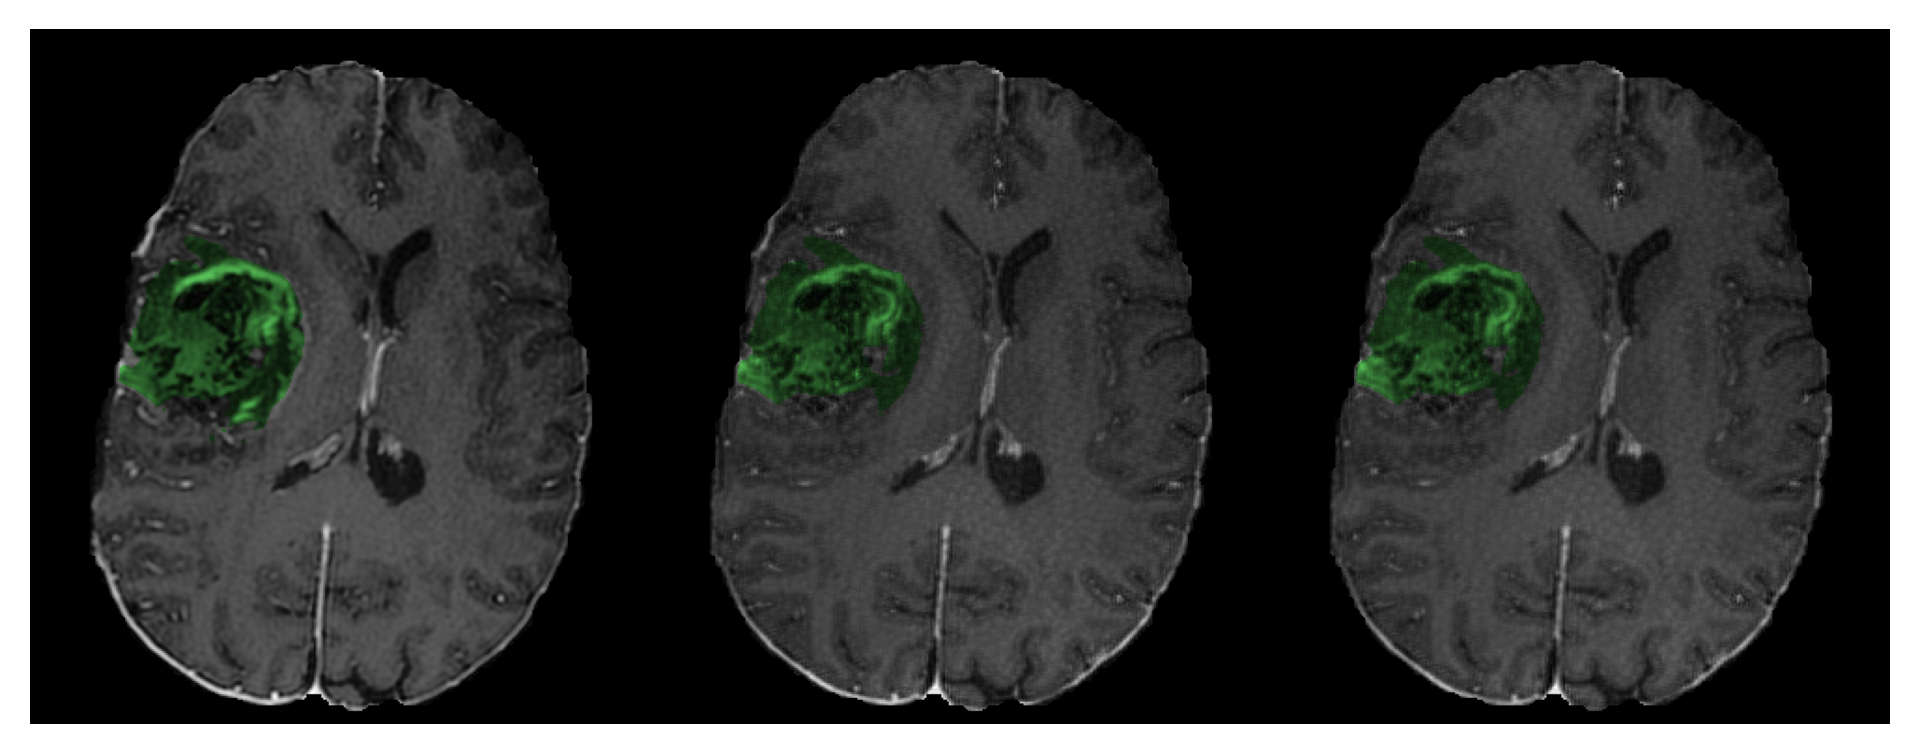

In [30]:
def get_plot_slice(fp, sl, x1, x2, y1, y2, mask=False):
    nib_data = nib.load(fp)
    if mask:
        nib_data = largest_connected_component_img(nib_data)
        
    data = nib_data.get_fdata()[..., sl]
    
    data = np.rot90(data, k=3)
    data = data / data.mean()
    data = data[x1:x2, y1:y2]
    return data

case = 'Patient_0059'
sl = 156
base_path = '/home/srivathsa/projects/studies/gad/dose_sim_seg'
kwargs = {'sl': sl, 'x1': 80, 'x2': -60, 'y1': 80, 'y2': -100}

data1 = get_plot_slice('{}/cases/{}/{}_T1Gd.nii.gz'.format(base_path, case, case), **kwargs)
data2 = get_plot_slice('{}/cases_sgad/{}/{}_T1Gd.nii.gz'.format(base_path, case, case), **kwargs)
data3 = get_plot_slice('{}/cases_sgad_sim/{}/{}_T1Gd.nii.gz'.format(base_path, case, case), **kwargs)

mask1 = get_plot_slice('{}/pred/{}_T1Gd/{}_T1Gd_seg.nii.gz'.format(base_path, case, case), mask=True, **kwargs)
mask2 = get_plot_slice('{}/pred_sgad/{}_T1Gd/{}_T1Gd_seg.nii.gz'.format(base_path, case, case), mask=True, **kwargs)
mask3 = get_plot_slice('{}/pred_sgad_sim/{}_T1Gd/{}_T1Gd_seg.nii.gz'.format(base_path, case, case), mask=True, **kwargs)

img1 = overlay_mask(data1, mask1, g=1.0, r=0, b=0)
img2 = overlay_mask(data2, mask2, g=1.0, r=0, b=0)
img3 = overlay_mask(data3, mask3, g=1.0, r=0, b=0)

plt.imshow(np.hstack([img1, img2, img3]))
plt.axis('off')

## Quant metrics

In [ ]:
from subtle.subtle_metrics import psnr, ssim

base_path = '/home/srivathsa/projects/studies/gad/dose_sim_seg'
cases = sorted([c.split('/')[-1] for c in glob('{}/cases/*'.format(base_path))])
quant_rows = []

for cnum in tqdm(cases, total=len(cases)):
    gad_gt = nib.load('{}/cases/{}/{}_T1Gd.nii.gz'.format(base_path, cnum, cnum)).get_fdata()
    gad_ld = nib.load('{}/cases_sgad/{}/{}_T1Gd.nii.gz'.format(base_path, cnum, cnum)).get_fdata()
    gad_ld_sim = nib.load('{}/cases_sgad_sim/{}/{}_T1Gd.nii.gz'.format(base_path, cnum, cnum)).get_fdata()
    
    sl = gad_gt.shape[-1] // 2
    
    p1 = psnr(gad_gt[..., sl], gad_ld[..., sl], dynamic_range=1.)
    p2 = psnr(gad_gt[..., sl], gad_ld_sim[..., sl], dynamic_range=1.)
    s1 = ssim(gad_gt[..., sl], gad_ld[..., sl], dynamic_range=1.)
    s2 = ssim(gad_gt[..., sl], gad_ld_sim[..., sl], dynamic_range=1.)
    
    qrow = {
        'Case': cnum,
        'PSNR_LD': p1,
        'PSNR_LD_SIM': p2,
        'SSIM_LD': s1,
        'SSIM_LD_SIM': s2
    }
    quant_rows.append(qrow)

In [ ]:
df_quant = pd.DataFrame(quant_rows)
df_quant.agg(['mean', 'std'])